# Mayhew preprocessing and models on Mayhew dataset

In [1]:
import pandas as pd
from xgboost import XGBClassifier, cv
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.compose import ColumnTransformer
import numpy as np

SEED=0

# Load the dataset
- Load data from excel sheet
- Set X (independent variables) and y (dependent variables) 

In [2]:
data_path = './data/mayhew1.csv'
na_values=['na']
df = pd.read_csv(data_path)
# smiles =  np.loadtxt("./data/smiles.txt", dtype='str')
y=df['odor.class'] # labels, independent variables
y = y.replace(['Odor'], True)
y = y.replace(['Odorless'], False)
assigned = df['dataset.assigned']
df = df.drop(['odor.class.source', 'dataset.assigned', 'odor.class', 
              'transport.ML.odor.probability', 'many.feature.ML.odor.probability'], axis=1)
df = df.set_index('SMILES')
X = df
df

,boiling.point.experimental,boiling.point.estimate.EPISuite,boiling.point.estimate.Banks,boiling.point.estimate.Burnop,boiling.point.best.available,vapor.pressure.experimental,vapor.pressure.best.available,MW,AMW,Sv,...,Psychotic.80,Psychotic.50,Hypertens.80,Hypertens.50,Hypnotic.80,Hypnotic.50,Neoplastic.80,Neoplastic.50,Infective.80,Infective.50
SMILES,,,,,,,,,,,,,,,,,,,,,
CC1=CC[C@H](CC1=O)C(=C)C,228.5,224.23,177.316328,211.376140,228.50,0.103000,0.103000,150.24,6.010,14.402,...,0,0,0,0,0,0,0,0,1,0
CC(=O)OC1CC(CC=C1C)C(=C)C,NaN,245.13,220.067558,267.379260,245.13,NaN,0.035300,194.30,6.072,18.171,...,0,0,0,0,1,0,1,0,1,0
CCC(=O)OC1CC(CC=C1C)C(=C)C,NaN,262.43,231.359855,283.769094,262.43,NaN,0.013900,208.33,5.952,19.698,...,0,0,1,0,1,0,1,0,1,0
CC1CC(C)(C)c2c(C1(C)C)cc(c(c2)C(=O)C)C,NaN,331.88,265.346589,354.216698,331.88,0.000512,0.000512,258.44,5.743,25.563,...,0,0,0,0,0,0,0,0,1,0
CC1=CCC(CC1)(O)C(C)C,209.0,211.85,181.799762,205.923187,209.00,NaN,0.042700,154.28,5.320,15.456,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CC(=CCC(CO)C(=C)C)C,NaN,221.70,181.799762,195.317301,221.70,NaN,0.019500,154.28,5.320,15.456,...,0,0,0,0,0,0,0,0,1,0
CC1=CCC(CC1O)C(=C)C,228.0,230.02,179.574801,208.589955,228.00,NaN,0.013200,152.26,5.639,14.929,...,0,0,0,0,0,0,0,0,1,0
C=CC(=O)OCC1CCCO1,NaN,201.85,183.884293,99.383370,201.85,NaN,0.329000,156.20,6.791,13.305,...,0,0,0,0,0,0,0,0,0,0


# Split the dataset
- Split dataset into training and test set 
- Use equal proportions of odor/odorless class

In [3]:
assigned
train = assigned == 'train'
X_train = df.iloc[list(train[train].index)]
y_train = y.iloc[list(train[train].index)]
test = assigned == 'test'
X_test = df.iloc[list(test[test].index)]
y_test = y.iloc[list(test[test].index)]
val = assigned == 'validation'
X_val = df.iloc[list(val[val].index)]
y_val = y.iloc[list(val[val].index)]

print(f"Total number molecules in training set: {y_train.shape[0]}")
print(f"Odor: {y_train.value_counts()[True]}")
print(f"Odorless: {y_train.value_counts()[False]}")

print(f"\nTotal number molecules in test set: {y_test.shape[0]}")
print(f"Odor: {y_test.value_counts()[True]}")
print(f"Odorless: {y_test.value_counts()[False]}")

print(f"\nPercentage odorless {y_test.value_counts()[False]/y_test.shape[0]}")

Total number molecules in training set: 1864
Odor: 1575
Odorless: 289

Total number molecules in test set: 30
Odor: 20
Odorless: 10

Percentage odorless 0.3333333333333333


# Test Model 

In [4]:
def test_model(model, y_test, X_test, verbose=True):
    y_pred=model.predict(X_test)
    y_pred_probs=model.predict_proba(X_test)[:,1]
    
    if verbose:
        print("ROC_AUC (TEST):",metrics.roc_auc_score(y_test, y_pred_probs))
        print("\n\nCLASSIFICATION REPORT:\n",metrics.classification_report(y_test, y_pred))
        
        if hasattr(model, 'feature_importances_') and hasattr(X_test, 'columns'):
            feature_imp = pd.Series(model.feature_importances_,index=X_test.columns.values).sort_values(ascending=False)
            top_20 = feature_imp.nlargest(20)
            sns.barplot(x=top_20, y=top_20.index)
            plt.xlabel('Descriptor Importance Score')
            plt.ylabel('Descriptor')
            plt.title("Top descriptors")
            plt.show()
        
        fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_probs)  
        
        #create ROC curve
        plt.plot(fpr,tpr)
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
        
    return metrics.roc_auc_score(y_test, y_pred_probs) 

def test_model_cross_val(model, y_test, X_test, k=5, verbose=True):
    roc_auc_nans = cross_val_score(model, X_test, y_test, cv=k, scoring='roc_auc')
    print(f"AVERAGE CV={k} ROC_AUC (TEST): {np.mean(roc_auc_nans)}")
    print(f"AVERAGE CV={k} STD (TEST): {np.std(roc_auc_nans)}")

# Handle NaNs


In [5]:
from sklearn.impute import KNNImputer

def handleNaNsMayhew(X_tr, X_te, thresh=0.1): 
    nans = X.isna().mean(axis=0)
    # set threshold for percentage nans before we drop 
    X_thresh = nans[nans >= thresh]
    X_tr.drop(X_thresh.index, 
      axis=1, 
      inplace=True)
    X_te.drop(X_thresh.index, 
      axis=1, 
      inplace=True)
    
    imputer = KNNImputer(n_neighbors=2)
    X_tr = imputer.fit_transform(X_tr)
    X_te = imputer.transform(X_te)

    return X_tr, X_te

# Preprocessing

## Correlations

In [6]:
# create correlation  matrix
corr_matrix = X_train.corr().abs()
# select upper traingle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))
# Find index of columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.99)]
# drop the columns
X_test.drop(to_drop, axis=1)
X_train.drop(to_drop, axis=1)

,boiling.point.experimental,boiling.point.estimate.EPISuite,boiling.point.estimate.Banks,boiling.point.estimate.Burnop,vapor.pressure.experimental,MW,AMW,Sv,Se,Sp,...,Psychotic.80,Psychotic.50,Hypertens.80,Hypertens.50,Hypnotic.80,Hypnotic.50,Neoplastic.80,Neoplastic.50,Infective.80,Infective.50
SMILES,,,,,,,,,,,,,,,,,,,,,
CCC(=O)OC1CC(CC=C1C)C(=C)C,NaN,262.43,231.359855,283.769094,NaN,208.33,5.952,19.698,34.491,21.523,...,0,0,1,0,1,0,1,0,1,0
CC1=CCC(CC1)(O)C(C)C,209.0,211.85,181.799762,205.923187,NaN,154.28,5.320,15.456,28.280,17.307,...,0,0,0,0,0,0,0,0,1,0
CC1=CC[C@](CC1)(O)C(C)C,209.0,211.85,181.799762,205.923187,NaN,154.28,5.320,15.456,28.280,17.307,...,0,0,0,0,0,0,0,0,1,0
O=C1C2(C)CCC(C1(C)C)C2,193.0,203.89,179.574801,104.485216,0.817,152.26,5.639,14.929,26.396,16.546,...,0,0,0,0,0,0,0,0,1,0
OCC1=CC[C@H](CC1)C(=C)C,244.0,241.19,179.574801,208.589955,NaN,152.26,5.639,14.929,26.396,16.546,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CC(=CCC(CO)C(=C)C)C,NaN,221.70,181.799762,195.317301,NaN,154.28,5.320,15.456,28.280,17.307,...,0,0,0,0,0,0,0,0,1,0
CC1=CCC(CC1O)C(=C)C,228.0,230.02,179.574801,208.589955,NaN,152.26,5.639,14.929,26.396,16.546,...,0,0,0,0,0,0,0,0,1,0
C=CC(=O)OCC1CCCO1,NaN,201.85,183.884293,99.383370,NaN,156.20,6.791,13.305,23.284,13.932,...,0,0,0,0,0,0,0,0,0,0


## Handle NaNs

In [7]:
X_train, X_test = handleNaNsMayhew(X_train.copy(), X_test.copy())

## Normalise 

In [8]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)

# Random Forest Model

https://www.datacamp.com/tutorial/random-forests-classifier-python

In [9]:
# set random state to 0 to allow reproducible results
clf=RandomForestClassifier(random_state=SEED, n_estimators=100) 

# For readability
y_train_rf = y_train
y_test_rf = y_test
X_train_rf = X_train
X_test_rf = X_test

In [10]:
clf.fit(X_train_rf, y_train_rf)
test_model_cross_val(clf, y_train_rf, X_train_rf, k=5, verbose=True)

AVERAGE CV=5 ROC_AUC (TEST): 0.9238309374969992
AVERAGE CV=5 STD (TEST): 0.045188914685868754


ROC_AUC (TEST): 0.9700000000000001


CLASSIFICATION REPORT:
               precision    recall  f1-score   support

       False       1.00      0.80      0.89        10
        True       0.91      1.00      0.95        20

    accuracy                           0.93        30
   macro avg       0.95      0.90      0.92        30
weighted avg       0.94      0.93      0.93        30



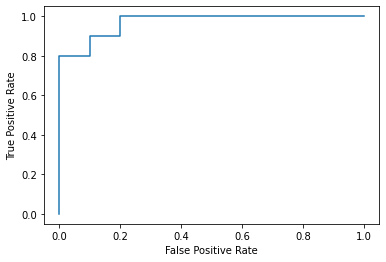

0.9700000000000001

In [11]:
tuned_rf = clf
clf.fit(X_train_rf, y_train_rf)
test_model(clf, y_test_rf, X_test_rf)

# XgBoost

https://practicaldatascience.co.uk/machine-learning/how-to-create-a-classification-model-using-xgboost

In [12]:
# for readibility 
y_train_xgb = y_train
y_test_xgb = y_test
X_train_xgb = X_train
X_test_xgb = X_test

## Create model

In [13]:
# X_train_xgb.columns = X_train_xgb.columns.str.translate("".maketrans({"[":"{", "]":"}","<":"^"}))
# X_test_xgb.columns = X_test_xgb.columns.str.translate("".maketrans({"[":"{", "]":"}","<":"^"}))

xgb = XGBClassifier(random_state=SEED, learning_rate=0.1, n_estimators=100, reg_lambda=0.2, reg_alpha=0.4, eta=0.3)
xgb.fit(X_train_xgb, y_train_xgb)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [14]:
xgb.fit(X_train_xgb, y_train_xgb)
test_model_cross_val(xgb, y_train_xgb, X_train_xgb, k=5, verbose=True)

AVERAGE CV=5 ROC_AUC (TEST): 0.9291836871873169
AVERAGE CV=5 STD (TEST): 0.041040060975134525


ROC_AUC (TEST): 0.965


CLASSIFICATION REPORT:
               precision    recall  f1-score   support

       False       0.89      0.80      0.84        10
        True       0.90      0.95      0.93        20

    accuracy                           0.90        30
   macro avg       0.90      0.88      0.88        30
weighted avg       0.90      0.90      0.90        30



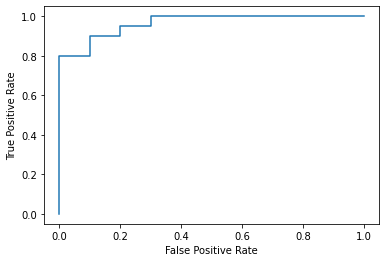

0.965

In [15]:
xgb.fit(X_train_xgb, y_train_xgb)
test_model(xgb, y_test_xgb, X_test_xgb)